In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
from dateutil.relativedelta import *
from collections import defaultdict

### Import Data

In [2]:
# Get historical crypto market cap rank data
cryptoMarketCapRankDf = pd.read_csv('data\CryptoMarketCap.csv')
cryptoMarketCapRankDf['Date'] = pd.to_datetime(cryptoMarketCapRankDf['Date'])

In [3]:
# Get historical crypto price data
cryptoPriceDf = pd.read_csv('data\TradingViewCryptoPrice.csv', index_col=0)
cryptoPriceDf.index = pd.to_datetime(cryptoPriceDf.index)

### Formation Period

In [4]:
def marketCapCryptoSelection(cryptoMarketCapRankDf, cutoffDate, cutoffRank):
    # Get formation period sample crypto list
    marketCapCutoffDate = pd.to_datetime(cutoffDate) - timedelta(days=1)
    sampleCrypto = cryptoMarketCapRankDf[(cryptoMarketCapRankDf['Date'] == marketCapCutoffDate) & (cryptoMarketCapRankDf['Rank'] <= cutoffRank)]
    sampleCrypto = list(sampleCrypto['Symbol'])
    return sampleCrypto

In [5]:
def cryptoPriceCleaning(cryptoPriceDf, sampleCrypto, cutoffDate, lookback):
    # Fliter the crypto with formation period
    cutoffRowIdx = cryptoPriceDf.index.get_loc(cutoffDate)
    if cutoffRowIdx < lookback:
        # if there is not enough got the whole lookback period, just get all the availiable data
        sampleCryptoPrice = cryptoPriceDf.iloc[:cutoffRowIdx]
    else:
        sampleCryptoPrice = cryptoPriceDf.iloc[cutoffRowIdx-lookback:cutoffRowIdx]
    
    # Filter based on the availiablity of crpyto price
    sampleCrypto = set(sampleCrypto).intersection([x[7:-3] for x in sampleCryptoPrice.columns])

    # Data Cleaning
    sampleCryptoPrice = sampleCryptoPrice[["CRYPTO:" + x + "USD" for x in sampleCrypto]]
    sampleCryptoPrice = sampleCryptoPrice.ffill(axis=0)
    sampleCryptoPrice = sampleCryptoPrice.dropna(axis=1)

    print('Remaining number of crpyto: ', len(sampleCryptoPrice.columns))

    return sampleCryptoPrice

#### Distance Method

In [6]:
def distanceMethodSelection(sampleCryptoPrice):
    # Normalized the log price
    sampleCryptoLogPrice = np.log(sampleCryptoPrice)
    sampleCryptoNormalizedLogPrice = (sampleCryptoLogPrice - sampleCryptoLogPrice.mean())/sampleCryptoLogPrice.std()

    # SSD calculation for each pair
    SSDResults = []
    for i in range(len(sampleCryptoNormalizedLogPrice.columns)):
        for j in range(i+1, len(sampleCryptoNormalizedLogPrice.columns)):
            SSD = ((sampleCryptoNormalizedLogPrice[sampleCryptoNormalizedLogPrice.columns[i]] - sampleCryptoNormalizedLogPrice[sampleCryptoNormalizedLogPrice.columns[j]]) ** 2).sum()
            SSDResults.append([sampleCryptoNormalizedLogPrice.columns[i], sampleCryptoNormalizedLogPrice.columns[j], SSD])
    
    # Return the SSD results
    SSDResults = pd.DataFrame(SSDResults, columns=['Crypto 1', 'Crypto 2', 'SSD'])
    SSDResults = SSDResults.sort_values('SSD', ascending=True)
    SSDResults = SSDResults.reindex()
    
    return SSDResults

### Trading Period

In [7]:
def distanceMethodTrading(cryptoPriceDf, sampleCryptoPrice, SSDResults, cutoffDate, forward, noTradingPairs, spreadThreshold, closeThreshold, constantModel=True):
    
    # initialize the records dataframe
    TransactionRecords = pd.DataFrame(columns=['Date', 'Crypto', 'Long/Short', 'Price', "Open/Close", "Transaction pair", "Round Trip No.", "Pair No."])
    SpreadRecords = pd.DataFrame()
    PairNo = 0

    # get trading crpyto price
    cutoffRowIdx = cryptoPriceDf.index.get_loc(cutoffDate)
    if cutoffRowIdx + forward > len(cryptoPriceDf):
        # if there is not enough got the whole forward period, just get all the availiable data
        tradingCryptoPrice = cryptoPriceDf.iloc[cutoffRowIdx:]
    else:
        tradingCryptoPrice = cryptoPriceDf.iloc[cutoffRowIdx:cutoffRowIdx+forward]

    logSampleCrpytoPrice = np.log(sampleCryptoPrice)
    logTradingCryptoPrice = np.log(tradingCryptoPrice)

    for i in range(noTradingPairs):
        ############ Trading Signal Calculation ############

        # Parameter
        crypto1 = SSDResults.loc[i, 'Crypto 1']
        crypto2 = SSDResults.loc[i, 'Crypto 2']

        # Calculate normalized spread
        if constantModel:
            # constant model parameter
            crypto1Mean = logSampleCrpytoPrice.mean()[crypto1]
            crypto2Mean = logSampleCrpytoPrice.mean()[crypto2]
            crypto1SD = logSampleCrpytoPrice.std()[crypto1]
            crypto2SD = logSampleCrpytoPrice.std()[crypto2]

            # calculate spread
            normalizedCrypto1LogPrice = (logTradingCryptoPrice[crypto1] - crypto1Mean)/crypto1SD
            normalizedCrypto2LogPrice = (logTradingCryptoPrice[crypto2] - crypto2Mean)/crypto2SD
            Spread = normalizedCrypto1LogPrice - normalizedCrypto2LogPrice

        else:
            # Expending window model
            logCrypto1Price = pd.concat([logSampleCrpytoPrice[crypto1],logTradingCryptoPrice[crypto1]], axis=0)
            logCrypto2Price = pd.concat([logSampleCrpytoPrice[crypto2],logTradingCryptoPrice[crypto2]], axis=0)
            crypto1Mean = logCrypto1Price.expanding(min_periods=1).mean() # or df.rolling(window=len(df), min_periods=1).mean()
            crypto2Mean = logCrypto2Price.expanding(min_periods=1).mean()
            crypto1SD = logCrypto1Price.expanding(min_periods=1).std()
            crypto2SD = logCrypto2Price.expanding(min_periods=1).std()

            # calculate spread
            normalizedCrypto1LogPrice = (logCrypto1Price- crypto1Mean)/crypto1SD
            normalizedCrypto2LogPrice = (logCrypto2Price - crypto2Mean)/crypto2SD
            Spread = normalizedCrypto1LogPrice - normalizedCrypto2LogPrice
            Spread = Spread.loc[cutoffDate:]

        ############ Trading Execution ############
        # check if there is any trading opportunity
        SpreadWithoutLastDay = Spread.iloc[:-1]
        if len(SpreadWithoutLastDay[(SpreadWithoutLastDay >= spreadThreshold) | (SpreadWithoutLastDay <= -spreadThreshold)]) > 0:
            
            # save the spread records
            Spread.name = crypto1 + " " + crypto2
            SpreadRecords = SpreadRecords.merge(Spread, how='outer', left_index=True, right_index=True)

            # initialize before the transaction
            PairNo += 1
            Spread.name = 'spread'
            Spread = Spread.to_frame()
            Opened = False
            long = None
            RoundTripNo = 1

            for date in Spread.index:

                # When the trading date is not the last day
                if date != Spread.index[-1]:
                    # If there is an open position before that date
                    if Opened:
                        # Close postion if the spread cross closeThreshold
                        if not long and Spread.loc[date, 'spread'] <= closeThreshold:
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto1, "Long",  tradingCryptoPrice.loc[date, crypto1], "Close", crypto2, RoundTripNo, PairNo]
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Short",  tradingCryptoPrice.loc[date, crypto2], "Close", crypto1, RoundTripNo, PairNo]
                            RoundTripNo += 1
                            long = None
                            Opened = False
                            
                        elif long and Spread.loc[date, 'spread'] >= -closeThreshold:
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto1, "Short",  tradingCryptoPrice.loc[date, crypto1], "Close", crypto2, RoundTripNo, PairNo]
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Long",  tradingCryptoPrice.loc[date, crypto2], "Close", crypto1, RoundTripNo, PairNo]
                            RoundTripNo += 1
                            long = None
                            Opened = False
                            
                    
                    # Check again if there is any position, if no and fulfil the criteria, then open position 
                    if not Opened:
                        # short crypto 1 and long crypto 2 if spread >= spreadThreshold
                        if Spread.loc[date, 'spread'] >= spreadThreshold:
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto1, "Short",  tradingCryptoPrice.loc[date, crypto1], "Open", crypto2, RoundTripNo, PairNo]
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Long",  tradingCryptoPrice.loc[date, crypto2], "Open", crypto1, RoundTripNo, PairNo]
                            long = False
                            Opened = True
                            
                        # long crypto 1 and short crypto 2 if spread <= -spreadThreshold
                        elif Spread.loc[date, 'spread'] <= -spreadThreshold:
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto1, "Long",  tradingCryptoPrice.loc[date, crypto1], "Open", crypto2, RoundTripNo, PairNo]
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Short",  tradingCryptoPrice.loc[date, crypto2], "Open", crypto1, RoundTripNo, PairNo]
                            long = True
                            Opened = True
                            

                # For last day closing position
                else:
                    if Opened:
                        if not long:
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto1, "Long",  tradingCryptoPrice.loc[date, crypto1], "Close", crypto2, RoundTripNo, PairNo]
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Short",  tradingCryptoPrice.loc[date, crypto2], "Close", crypto1, RoundTripNo, PairNo]
                            long = None
                            Opened = False
                            
                        else:
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto1, "Short",  tradingCryptoPrice.loc[date, crypto1], "Close", crypto2, RoundTripNo, PairNo]
                            TransactionRecords.loc[len(TransactionRecords)] = [date, crypto2, "Long",  tradingCryptoPrice.loc[date, crypto2], "Close", crypto1, RoundTripNo, PairNo]
                            long = None
                            Opened = False
                            
    return (TransactionRecords, SpreadRecords)

### Rolling Window

In [8]:
# General parameters
startDate = '2019-01-01'
endDate = '2023-07-01'
lookback =365
forward = 60

# Formation period parameters
cutoffRank = 100

# Trading period parameters
noTradingPairs = 50
spreadThreshold = 2.5
closeThreshold = -1 # same sign as spreadThreshold

In [9]:
TransactionRecords = pd.DataFrame(columns=['Date', 'Crypto', 'Long/Short', 'Price', "Open/Close", "Transaction pair",  "Period No.", "Pair No.", "Round Trip No."])
SpreadRecords = pd.DataFrame()

period = 1
for cutoffDate in pd.date_range(startDate, endDate, freq='2MS'):
    sampleCrypto = marketCapCryptoSelection(cryptoMarketCapRankDf, cutoffDate, cutoffRank)
    sampleCryptoPrice = cryptoPriceCleaning(cryptoPriceDf, sampleCrypto, cutoffDate, lookback)
    SSDResults = distanceMethodSelection(sampleCryptoPrice)
    Transaction, Spread = distanceMethodTrading(cryptoPriceDf, sampleCryptoPrice, SSDResults, cutoffDate, forward, noTradingPairs, spreadThreshold, closeThreshold, False)
    Transaction['Period No.'] = period
    TransactionRecords = pd.concat([TransactionRecords, Transaction], ignore_index=True)
    SpreadRecords = pd.concat([SpreadRecords, Spread])
    period += 1

Remaining number of crpyto:  45
Remaining number of crpyto:  51
Remaining number of crpyto:  55
Remaining number of crpyto:  49
Remaining number of crpyto:  47
Remaining number of crpyto:  48
Remaining number of crpyto:  46
Remaining number of crpyto:  47
Remaining number of crpyto:  49
Remaining number of crpyto:  52
Remaining number of crpyto:  52
Remaining number of crpyto:  57
Remaining number of crpyto:  60
Remaining number of crpyto:  58
Remaining number of crpyto:  62
Remaining number of crpyto:  63
Remaining number of crpyto:  66
Remaining number of crpyto:  67
Remaining number of crpyto:  65
Remaining number of crpyto:  65
Remaining number of crpyto:  68
Remaining number of crpyto:  77
Remaining number of crpyto:  84
Remaining number of crpyto:  78
Remaining number of crpyto:  82
Remaining number of crpyto:  82
Remaining number of crpyto:  88
Remaining number of crpyto:  88


### Transform transaction records to Result

In [10]:
result = pd.DataFrame(columns=['Period No.', 'Pair No.', 'Round Trip No.', 'Start Date', 'End Date', 'long crypto', 'short crypto', 'long crypto return', 'short crypto return'])
# loop each period
for k in range(1, TransactionRecords['Period No.'].max() + 1):
    period =  TransactionRecords[TransactionRecords['Period No.'] == k]
    
    # if there is no trade in that period
    if len(period) == 0:
        continue
    
    # loop each pair of transactions
    for i in range(1, period['Pair No.'].max() + 1):
        pair = period[period['Pair No.'] == i]
        # loop each Round Trip in pair
        for j in range(1, pair['Round Trip No.'].max() + 1):
            roundTrip = pair[pair['Round Trip No.'] == j]

            returnResult = dict()

            # loop each crypto in the round trip
            for crypto in set(roundTrip['Crypto']):
                
                # prepare the specific round trip transaction record
                record = roundTrip[roundTrip['Crypto'] == crypto]
                record = record.reset_index(drop=True)

                # Calculate the return of the specific round trip
                returns = record['Price'][1] / record['Price'][0] - 1
                if record['Long/Short'][0] == 'Short':
                    returns = -returns 
                
                # Insert Record
                if len(returnResult) == 0:
                    returnResult['Period No.'] = k
                    returnResult['Pair No.'] = i
                    returnResult['Round Trip No.'] = j
                    returnResult['Start Date'] = record['Date'][0]
                    returnResult['End Date'] = record['Date'][1]
                
                if record['Long/Short'][0] == 'Long':
                    returnResult['long crypto'] = crypto
                    returnResult['long crypto return'] = returns
                else:
                    returnResult['short crypto'] = crypto
                    returnResult['short crypto return'] = returns

            result.loc[len(result)] = returnResult  


In [11]:
# Remark: return can be more than -100% for the short selling position
result['Total Return'] = result['long crypto return'] + result['short crypto return']
result

,Period No.,Pair No.,Round Trip No.,Start Date,End Date,long crypto,short crypto,long crypto return,short crypto return,Total Return
0,1,1,1,2019-01-06,2019-03-01,CRYPTO:ADAUSD,CRYPTO:USDTUSD,-0.121768,0.015430,-0.106338
1,2,1,1,2019-04-19,2019-04-29,CRYPTO:ADAUSD,CRYPTO:BNBUSD,-0.195462,0.127620,-0.067842
2,2,2,1,2019-03-08,2019-04-29,CRYPTO:ADAUSD,CRYPTO:ENJUSD,0.508101,0.300986,0.809087
3,3,1,1,2019-05-24,2019-06-29,CRYPTO:ADAUSD,CRYPTO:BNBUSD,0.105445,-0.034104,0.071342
4,3,2,1,2019-05-16,2019-06-29,CRYPTO:ADAUSD,CRYPTO:LINKUSD,0.018474,-3.125683,-3.107209
...,...,...,...,...,...,...,...,...,...,...
230,28,9,1,2023-08-01,2023-08-29,CRYPTO:DYDXUSD,CRYPTO:MKRUSD,0.070669,0.215957,0.286627
231,28,10,1,2023-08-24,2023-08-29,CRYPTO:AVAXUSD,CRYPTO:DYDXUSD,0.069374,0.003368,0.072742
232,28,11,1,2023-08-17,2023-08-29,CRYPTO:EOSUSD,CRYPTO:DYDXUSD,0.091782,-0.152486,-0.060704
233,28,12,1,2023-08-16,2023-08-29,CRYPTO:DYDXUSD,CRYPTO:GUSDUSD,0.088853,0.019685,0.108538


In [ ]:
result.groupby('Period No.').mean()['Total Return']

### Daily Return

In [78]:
def getcumReturns(cryptoPriceDf, result):
    cumReturn = pd.DataFrame()
    # loop through each row
    for idx, row in result.iterrows():
        crpyto1StartPrice = cryptoPriceDf.loc[row['Start Date'], row['long crypto']]
        crpyto2StartPrice = cryptoPriceDf.loc[row['Start Date'], row['short crypto']]
        crpyto1cumReturn = cryptoPriceDf.loc[row['Start Date']:row['End Date'], row['long crypto']] / crpyto1StartPrice - 1
        crpyto2cumReturn = cryptoPriceDf.loc[row['Start Date']:row['End Date'], row['short crypto']] / crpyto2StartPrice - 1
        cumReturnSeries = crpyto1cumReturn - crpyto2cumReturn
        cumReturnSeries.name = row['long crypto'] + " " + row['short crypto'] + " " + str(row['Period No.']) + + " " + str(row['Round Trip No.'])
        cumReturn = cumReturn.merge(cumReturnSeries, left_index=True, right_index=True, how="outer")
    return cumReturn

In [102]:
cumReturns = getcumReturns(cryptoPriceDf, result)
dailyReturns = np.exp(np.log(cumReturns + 1).diff()) - 1 # OR (cumReturns + 1) / (cumReturns.shift(1) + 1) - 1
averageDailyReturn = dailyReturns.mean(axis=1)
averageDailyReturn = averageDailyReturn.fillna(0)
averageCumReturn = np.cumprod(1 +averageDailyReturn) - 1

C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


<AxesSubplot:xlabel='Date'>

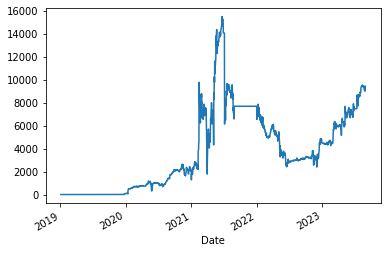

In [106]:
averageCumReturn.plot()

In [127]:
result.groupby(['Period No.']).count()['Total Return']

Period No.
1      1
2      2
3      2
4      2
5      1
6      2
7      8
8      8
9      8
10    26
11     4
12     6
13    15
14     6
15     5
16     3
19    18
20    21
21    42
22     4
23     8
24    12
25     5
26     9
27     2
28    13
Name: Total Return, dtype: int64

In [128]:
result.groupby(['Period No.']).mean()['Total Return']

C:\Users\harry\AppData\Local\Temp\ipykernel_18812\64978782.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result.groupby(['Period No.']).mean()['Total Return']


Period No.
1    -0.106338
2     0.370623
3    -1.517934
4     0.056517
5    -0.400763
6    -0.348116
7     0.610763
8     0.336026
9     0.053360
10    0.413664
11    0.198323
12    0.056355
13   -0.454544
14   -0.116344
15    0.275704
16   -0.058741
19   -0.226808
20   -0.001145
21   -0.294625
22    0.055261
23    0.026263
24    0.035196
25   -0.010445
26    0.057317
27    0.167848
28    0.043607
Name: Total Return, dtype: float64

<AxesSubplot:xlabel='Date'>

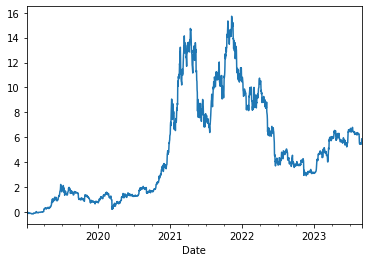

In [117]:
(cryptoPriceDf.loc[averageCumReturn.index[0]:averageCumReturn.index[-1], 'CRYPTO:BTCUSD'] / cryptoPriceDf.loc[averageCumReturn.index[0], 'CRYPTO:BTCUSD'] - 1).plot()

### TO-DO list:
1) create a time series chart (input pair No.) and show the pair daily return over the period and spread over the period (SpreadRecords)
2) make a function to loop the above process each two months and return both the transaction records and transform it to result [OK]
3) Price should be normalized to the first day of the trading period [Solved]
